# Introduction and Business Problem

Hoboken, NJ is a busy place and can be overwhelming for people who are either new the city or just visiting. For visitors, you have a limited amount of time and money to get the best experience out of the city. In order to get the best experience, visitors should figure out where their money will be best spent. So the question becomes, how can you know what the best restaurants are? 

For this project, I will create a simplistic guide to eating out in Hoboken using data retreived from Foursquare such as likes, restaurant category  and location. Once these restaurants are clustered, it will be easy for visitors to determine the best investement of their money so as to gain the best personalized experience in Hoboken.

# Data Required

The data required to complete this project includes venue names, IDs, location, categories, and number of likes.

To aquire the above mentioned data, I will need to us the geolocator for latitudes and longitudes for Hoboken venues and use the Foursquare API to retrieve a list of venues with their cooresponding attributes.

Once the above data has been gathered and sorted, I will create a k-means clusteering algorithm to group the restaurants. This will allow visitors to easily see which restaurants are the best to eat at and what kind of cuisine is available. 

# Data Prep and Pull

In [44]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#import beautiful soup
from urllib.request import urlopen
from bs4 import BeautifulSoup


print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


Finding the geo data for Hoboken

In [45]:
address = 'Hoboken, New Jersey'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Hoboken are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Hoboken are 40.7433066, -74.0323752.


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


Entering in our information into the Foursquare API

In [47]:
CLIENT_ID = 'LNS0G1ICAJ1QUORBN14EKMY055R53TATRY451B5UZVJEINUR' # your Foursquare ID
CLIENT_SECRET = 'PUKT1UMBWBGW2RQELELCOS0JBDJJST2H3HQ0TPHGWL3AG1N0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LNS0G1ICAJ1QUORBN14EKMY055R53TATRY451B5UZVJEINUR
CLIENT_SECRET:PUKT1UMBWBGW2RQELELCOS0JBDJJST2H3HQ0TPHGWL3AG1N0


Creating a URL  for all of the Venues in Hoboken

In [48]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=LNS0G1ICAJ1QUORBN14EKMY055R53TATRY451B5UZVJEINUR&client_secret=PUKT1UMBWBGW2RQELELCOS0JBDJJST2H3HQ0TPHGWL3AG1N0&v=20180605&ll=40.7433066,-74.0323752&radius=500&limit=100'

Pulling the JSON for the URL of venues.

In [49]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e413c04bae9a2001b3334b9'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Hoboken',
  'headerFullLocation': 'Hoboken',
  'headerLocationGranularity': 'city',
  'totalResults': 106,
  'suggestedBounds': {'ne': {'lat': 40.7478066045, 'lng': -74.0264467971303},
   'sw': {'lat': 40.738806595499995, 'lng': -74.0383036028697}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4cdf46dadb125481eb4236ce',
       'name': 'Work It Out-A Fitness Boutique',
       'location': {'address': '603 Willow Ave',
        'lat': 40.744356367758414,
        'lng': -74.03256658205021,
        'labeledLatLngs': [{'label': 'displa

We start pulling the data from Foursquare into a dataframe so we can manipulate and use it.

In [50]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    
    if len(categories_list) ==0:
        return None
    else:
        return categories_list[0]['name']

In [51]:
#pull the actual data from the Foursquare API

venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
filtered_columns = ['venue.name', 'venue.id', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues

,venue.name,venue.id,venue.categories,venue.location.lat,venue.location.lng
0,Work It Out-A Fitness Boutique,4cdf46dadb125481eb4236ce,Gym / Fitness Center,40.744356,-74.032567
1,Sweet,4a4e740ff964a5207bae1fe3,Bakery,40.741623,-74.031523
2,Grand Vin,56d3b920498ec4e1c67c0907,Cocktail Bar,40.743209,-74.035099
3,Karma Kafe,582dfc9565be5809f6a964ed,Indian Restaurant,40.742373,-74.029376
4,Church Square Park,49e9e49df964a5200a661fe3,Park,40.742152,-74.032230
5,Kung Fu Tea,57168865498e9517f09fa03d,Bubble Tea Shop,40.743347,-74.029379
6,Anthropologie,51f1c7e1498e7425c21efab6,Women's Store,40.741838,-74.029662
7,Onieal's Restaurant & Bar,45e9482df964a52075431fe3,Pub,40.741608,-74.032304
8,O'Bagel,56daf06fcd107605ef3d86ea,Bagel Shop,40.743603,-74.029173
9,Fiore's House of Quality,4a1098a2f964a520e3761fe3,Deli / Bodega,40.743019,-74.036183


In [52]:
#fix the column names so they look relatively normal

nearby_venues.column = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  app.launch_new_instance()


,venue.name,venue.id,venue.categories,venue.location.lat,venue.location.lng
0,Work It Out-A Fitness Boutique,4cdf46dadb125481eb4236ce,Gym / Fitness Center,40.744356,-74.032567
1,Sweet,4a4e740ff964a5207bae1fe3,Bakery,40.741623,-74.031523
2,Grand Vin,56d3b920498ec4e1c67c0907,Cocktail Bar,40.743209,-74.035099
3,Karma Kafe,582dfc9565be5809f6a964ed,Indian Restaurant,40.742373,-74.029376
4,Church Square Park,49e9e49df964a5200a661fe3,Park,40.742152,-74.032230
5,Kung Fu Tea,57168865498e9517f09fa03d,Bubble Tea Shop,40.743347,-74.029379
6,Anthropologie,51f1c7e1498e7425c21efab6,Women's Store,40.741838,-74.029662
7,Onieal's Restaurant & Bar,45e9482df964a52075431fe3,Pub,40.741608,-74.032304
8,O'Bagel,56daf06fcd107605ef3d86ea,Bagel Shop,40.743603,-74.029173
9,Fiore's House of Quality,4a1098a2f964a520e3761fe3,Deli / Bodega,40.743019,-74.036183


In [59]:
#find a list of unique categories from the API so we can see what may or may not fit for restaurants

nearby_venues['venue.categories'].unique()

array(['Gym / Fitness Center', 'Bakery', 'Cocktail Bar',
       'Indian Restaurant', 'Park', 'Bubble Tea Shop', "Women's Store",
       'Pub', 'Bagel Shop', 'Deli / Bodega', 'Sporting Goods Shop',
       'Falafel Restaurant', 'Coffee Shop', 'American Restaurant',
       'Sushi Restaurant', 'Burger Joint', 'Cuban Restaurant',
       'Gaming Cafe', 'Pizza Place', 'Seafood Restaurant',
       'South American Restaurant', 'Ice Cream Shop', 'Pet Store', 'Bar',
       'Yoga Studio', 'Shoe Repair', 'Italian Restaurant', 'Optical Shop',
       'Mexican Restaurant', 'Japanese Restaurant', 'Dog Run',
       'Jewelry Store', 'Sandwich Place', 'Boutique',
       'Paper / Office Supplies Store', 'Business Service',
       'Mediterranean Restaurant', 'Poke Place', 'Cosmetics Shop',
       'Donut Shop', 'Record Shop', 'Sports Bar', 'Thai Restaurant',
       'Korean Restaurant', 'Grocery Store', 'Juice Bar',
       'Stationery Store', 'Liquor Store', 'Restaurant', 'Pilates Studio',
       'Salon / Bar

In [60]:

# creating a list of categorie to remove from our dataframe because they are not restaurants
# I am sure there is a function that can be written to do this at scale but since it was a small list, I did it manually

removal_list = ['Gym / Fitness Center', 'Bakery', 'Park', "Women's Store", 'Sporting Goods Shop', 'Dog Run', 'Gaming Cafe',
               'Optical Shop', 'Yoga Studio', 'Pet Store', 'Shoe Repair', 'Jewelry Store', 'Record Shop', 'Juice Bar', 
               'Cosmetics Shop', 'Business Service', 'Salon / Barbershop', 'Liquor Store', 'Grocery Store', 'Stationery Store',
               'Pilates Studio', 'Dessert Shop', 'Bookstore', 'Concert Hall', 'Video Game Store', 'Pharmacy', 'Mobile Phone Shop',
               'Deli / Bodega']

nearby_venues2 = nearby_venues.copy()


#getting a clear dataframe of just restaurants
nearby_venues2 = nearby_venues2[~nearby_venues2['venue.categories'].isin(removal_list)]
nearby_venues2

,venue.name,venue.id,venue.categories,venue.location.lat,venue.location.lng
2,Grand Vin,56d3b920498ec4e1c67c0907,Cocktail Bar,40.743209,-74.035099
3,Karma Kafe,582dfc9565be5809f6a964ed,Indian Restaurant,40.742373,-74.029376
5,Kung Fu Tea,57168865498e9517f09fa03d,Bubble Tea Shop,40.743347,-74.029379
7,Onieal's Restaurant & Bar,45e9482df964a52075431fe3,Pub,40.741608,-74.032304
8,O'Bagel,56daf06fcd107605ef3d86ea,Bagel Shop,40.743603,-74.029173
13,Mamoun's Falafel,4d9368407b5ea1437d14c8b8,Falafel Restaurant,40.742303,-74.029465
14,Empire Coffee & Tea,49f37b88f964a520a26a1fe3,Coffee Shop,40.741375,-74.030515
15,Court Street Bar & Restaurant,4a7eff1cf964a5206ff21fe3,American Restaurant,40.743322,-74.028615
16,Ayame Hibachi & Sushi,4dbc9859f7b1ab37dd636d12,Sushi Restaurant,40.743105,-74.029213
18,Zack's Oak Bar & Restaurant,49f26862f964a520296a1fe3,American Restaurant,40.740640,-74.033826


Lets generate a list of venue ids so we can pull likes and add to our dataframe.

In [62]:
#let's get a list of venues

venue_id_list = nearby_venues2['venue.id'].tolist()
venue_id_list

['56d3b920498ec4e1c67c0907',
 '582dfc9565be5809f6a964ed',
 '57168865498e9517f09fa03d',
 '45e9482df964a52075431fe3',
 '56daf06fcd107605ef3d86ea',
 '4d9368407b5ea1437d14c8b8',
 '49f37b88f964a520a26a1fe3',
 '4a7eff1cf964a5206ff21fe3',
 '4dbc9859f7b1ab37dd636d12',
 '49f26862f964a520296a1fe3',
 '53ed3b37498e4151087521a9',
 '4eb1b6859adfb95b77765bf9',
 '4d4218cd607b6dcb31df08c6',
 '4cdb36c1958f236a15a7ab03',
 '4ca50f407334236a60ef1258',
 '57f83f7acd10164c2ec1956f',
 '49e2a407f964a52045621fe3',
 '49dfb562f964a52001611fe3',
 '4ad12c5ef964a5203ddd20e3',
 '58e7ed715f67173549fe6246',
 '4c60c4a1de6920a111ed9664',
 '4a9ac1b1f964a520813220e3',
 '4a7b5b6bf964a520c8ea1fe3',
 '527f3d1711d2f7f001c656b2',
 '49ee57f6f964a5204f681fe3',
 '4a9578dff964a520562320e3',
 '4ad89c0bf964a520d31221e3',
 '4a8da189f964a520501020e3',
 '4bddbf6be75c0f47f171c503',
 '5df2bca6775cb40008715de3',
 '5a6b6047f427de038c51031c',
 '58c470fd37da1d593431c33a',
 '56f136ad498ecc5661aa49ce',
 '4b191a58f964a520ffd723e3',
 '4a3ad481f964

In [63]:
#set up to pull the likes from the API based on venue ID

url_list = []
like_list = []
json_list = []

for i in venue_id_list:
    venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
    url_list.append(venue_url)
for link in url_list:
    result = requests.get(link).json()
    likes = result['response']['likes']['count']
    like_list.append(likes)
print(like_list)

[71, 42, 30, 154, 69, 268, 133, 103, 71, 120, 85, 169, 184, 83, 139, 33, 105, 65, 46, 71, 65, 166, 37, 55, 13, 76, 22, 74, 4, 0, 38, 24, 11, 38, 71, 106, 5, 71, 46, 50, 16, 17, 6, 69, 34, 121, 23, 121, 10, 111, 27, 20, 47, 15, 22, 18, 17, 19, 6, 9]


In [64]:
#double check that we did not lose any venues based on if likes were available

print(len(like_list))
print(len(venue_id_list))

60
60


# Intro to Data Prep

The more likes that a restaurant has the better the restaurant is. This data will be binned into categorical variables so we can cluster appropriately.

I will create new categorical variables for the restaurants to better gorup them based on type of food. This means you can look for best restaurants based on type of cuisine in Hoboken if you are new to the area.

# Data Prep - 1 

To prep the data for clustering - This includes combining data, creating new categorical data, binning data and encoding the data for clustering.

In [65]:
#let's make a copy of our initial dataframe just in case anything goes wrong

hoboken_venues = nearby_venues2.copy()
hoboken_venues.head()

,venue.name,venue.id,venue.categories,venue.location.lat,venue.location.lng
2,Grand Vin,56d3b920498ec4e1c67c0907,Cocktail Bar,40.743209,-74.035099
3,Karma Kafe,582dfc9565be5809f6a964ed,Indian Restaurant,40.742373,-74.029376
5,Kung Fu Tea,57168865498e9517f09fa03d,Bubble Tea Shop,40.743347,-74.029379
7,Onieal's Restaurant & Bar,45e9482df964a52075431fe3,Pub,40.741608,-74.032304
8,O'Bagel,56daf06fcd107605ef3d86ea,Bagel Shop,40.743603,-74.029173


# Data Prep - 2

Combining list of likes

In [67]:
# add in the list of likes

hoboken_venues['total likes']=like_list
hoboken_venues.head()

,venue.name,venue.id,venue.categories,venue.location.lat,venue.location.lng,total likes
2,Grand Vin,56d3b920498ec4e1c67c0907,Cocktail Bar,40.743209,-74.035099,71
3,Karma Kafe,582dfc9565be5809f6a964ed,Indian Restaurant,40.742373,-74.029376,42
5,Kung Fu Tea,57168865498e9517f09fa03d,Bubble Tea Shop,40.743347,-74.029379,30
7,Onieal's Restaurant & Bar,45e9482df964a52075431fe3,Pub,40.741608,-74.032304,154
8,O'Bagel,56daf06fcd107605ef3d86ea,Bagel Shop,40.743603,-74.029173,69


# Data Prep - 3

setting bins

In [68]:
# now let's bin total likes

print(hoboken_venues['total likes'].max())
print(hoboken_venues['total likes'].min())
print(hoboken_venues['total likes'].median())
print(hoboken_venues['total likes'].mean())

268
0
46.5
62.35


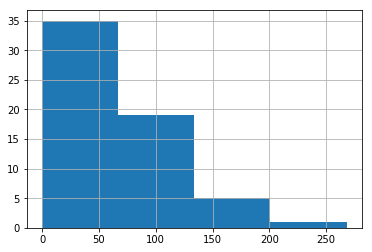

In [70]:
# Let's visualize our total likes based on a histogram

import matplotlib.pyplot as plt
hoboken_venues['total likes'].hist(bins=4)
plt.show()

In [71]:
# what are the bins we want to use?

print(np.percentile(hoboken_venues['total likes'], 25))
print(np.percentile(hoboken_venues['total likes'], 50))
print(np.percentile(hoboken_venues['total likes'], 75))

19.75
46.5
83.5


In [73]:
# now we have our bin values so let's set them to the appropriate values
# less than 24, 24-45, 45-76, 76>
# poor, below avg, abv avg, great

poor = hoboken_venues['total likes']<=24
below_avg = hoboken_venues[(hoboken_venues['total likes']>24) & (hoboken_venues['total likes']<=45)]
abv_avg = hoboken_venues[(hoboken_venues['total likes']>45) & (hoboken_venues['total likes']<=76)]
great = hoboken_venues['total likes']>76

In [74]:
# let's set up a function that will re-categorize our restaurants based on likes

def conditions(s):
    if s['total likes']<=24:
        return 'poor'
    if s['total likes']<=45:
        return 'below avg'
    if s['total likes']<=76:
        return 'avg avg'
    if s['total likes']>76:
        return 'great'

hoboken_venues['total likes_cat']=hoboken_venues.apply(conditions, axis=1)

In [75]:
hoboken_venues

,venue.name,venue.id,venue.categories,venue.location.lat,venue.location.lng,total likes,total likes_cat
2,Grand Vin,56d3b920498ec4e1c67c0907,Cocktail Bar,40.743209,-74.035099,71,avg avg
3,Karma Kafe,582dfc9565be5809f6a964ed,Indian Restaurant,40.742373,-74.029376,42,below avg
5,Kung Fu Tea,57168865498e9517f09fa03d,Bubble Tea Shop,40.743347,-74.029379,30,below avg
7,Onieal's Restaurant & Bar,45e9482df964a52075431fe3,Pub,40.741608,-74.032304,154,great
8,O'Bagel,56daf06fcd107605ef3d86ea,Bagel Shop,40.743603,-74.029173,69,avg avg
13,Mamoun's Falafel,4d9368407b5ea1437d14c8b8,Falafel Restaurant,40.742303,-74.029465,268,great
14,Empire Coffee & Tea,49f37b88f964a520a26a1fe3,Coffee Shop,40.741375,-74.030515,133,great
15,Court Street Bar & Restaurant,4a7eff1cf964a5206ff21fe3,American Restaurant,40.743322,-74.028615,103,great
16,Ayame Hibachi & Sushi,4dbc9859f7b1ab37dd636d12,Sushi Restaurant,40.743105,-74.029213,71,avg avg
18,Zack's Oak Bar & Restaurant,49f26862f964a520296a1fe3,American Restaurant,40.740640,-74.033826,120,great


In [77]:
#let's staar the process for re-categorizing the categories

hoboken_venues['venue.categories'].unique()

array(['Cocktail Bar', 'Indian Restaurant', 'Bubble Tea Shop', 'Pub',
       'Bagel Shop', 'Falafel Restaurant', 'Coffee Shop',
       'American Restaurant', 'Sushi Restaurant', 'Burger Joint',
       'Cuban Restaurant', 'Pizza Place', 'Seafood Restaurant',
       'South American Restaurant', 'Ice Cream Shop', 'Bar',
       'Italian Restaurant', 'Mexican Restaurant', 'Japanese Restaurant',
       'Sandwich Place', 'Boutique', 'Paper / Office Supplies Store',
       'Mediterranean Restaurant', 'Poke Place', 'Donut Shop',
       'Sports Bar', 'Thai Restaurant', 'Korean Restaurant', 'Restaurant',
       'Dive Bar', 'Nail Salon'], dtype=object)

In [78]:
# let's create our new categories and create a function to apply those to our existing data


bars = ['Pub', 'Cocktail Bar', 'Bar', 'Dive Bar', 'Sports Bar']
other = ['Bagel Shop', 'Tea Room', 'Donut Shop', 'Coffee Shop', 'Bubble Tea Shop', 'Sandwich Place', 'Boutique', 'Ice Cream Shop']
euro_asia_indian_food = ['Falafel Restaurant', 'Korean Restaurant','Sushi Restaurant', 'Indian Restaurant', 'Japanese Restaurant', 'Poke Place', 'Thai Restaurant', 'Vietnamese Restaurant']
mex_southam_food = ['Cuban Restaurant', 'Mexican Restaurant', 'South American Restaurant', 'Latin American Restaurant']
american_food = ['Burger Joint', 'Restaurant', 'American Restaurant']
italian_food = ['Italian Restaurant', 'Seafood Restaurant', 'Pizza Place']

def conditions2(s):
    if s['venue.categories'] in bars:
        return 'bars'
    if s['venue.categories'] in other:
        return 'other'
    if s['venue.categories'] in euro_asia_indian_food:
        return 'euro asia indian food'
    if s['venue.categories'] in mex_southam_food:
        return 'mex southam food'
    if s['venue.categories'] in american_food:
        return 'american food'
    if s['venue.categories'] in italian_food:
        return 'italian food'

hoboken_venues['categories_new']=hoboken_venues.apply(conditions2, axis=1)

In [79]:
hoboken_venues

,venue.name,venue.id,venue.categories,venue.location.lat,venue.location.lng,total likes,total likes_cat,categories_new
2,Grand Vin,56d3b920498ec4e1c67c0907,Cocktail Bar,40.743209,-74.035099,71,avg avg,bars
3,Karma Kafe,582dfc9565be5809f6a964ed,Indian Restaurant,40.742373,-74.029376,42,below avg,euro asia indian food
5,Kung Fu Tea,57168865498e9517f09fa03d,Bubble Tea Shop,40.743347,-74.029379,30,below avg,other
7,Onieal's Restaurant & Bar,45e9482df964a52075431fe3,Pub,40.741608,-74.032304,154,great,bars
8,O'Bagel,56daf06fcd107605ef3d86ea,Bagel Shop,40.743603,-74.029173,69,avg avg,other
13,Mamoun's Falafel,4d9368407b5ea1437d14c8b8,Falafel Restaurant,40.742303,-74.029465,268,great,euro asia indian food
14,Empire Coffee & Tea,49f37b88f964a520a26a1fe3,Coffee Shop,40.741375,-74.030515,133,great,other
15,Court Street Bar & Restaurant,4a7eff1cf964a5206ff21fe3,American Restaurant,40.743322,-74.028615,103,great,american food
16,Ayame Hibachi & Sushi,4dbc9859f7b1ab37dd636d12,Sushi Restaurant,40.743105,-74.029213,71,avg avg,euro asia indian food
18,Zack's Oak Bar & Restaurant,49f26862f964a520296a1fe3,American Restaurant,40.740640,-74.033826,120,great,american food


# Data Prep - 4

Creating Dummy variables for our total likes and categories for clustering

In [81]:
# one hot encoding
hoboken_onehot = pd.get_dummies(hoboken_venues[['categories_new', 'total likes_cat']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
hoboken_onehot['Name'] = hoboken_venues['venue.name'] 

# move neighborhood column to the first column
fixed_columns = [hoboken_onehot.columns[-1]] + list(hoboken_onehot.columns[:-1])
hoboken_onehot = hoboken_onehot[fixed_columns]

hoboken_onehot.head()

,Name,american food,bars,euro asia indian food,italian food,mex southam food,other,avg avg,below avg,great,poor
2,Grand Vin,0,1,0,0,0,0,1,0,0,0
3,Karma Kafe,0,0,1,0,0,0,0,1,0,0
5,Kung Fu Tea,0,0,0,0,0,1,0,1,0,0
7,Onieal's Restaurant & Bar,0,1,0,0,0,0,0,0,1,0
8,O'Bagel,0,0,0,0,0,1,1,0,0,0


# Clustering Part 1

Running the K-Means

In [82]:
cluster_df = hoboken_onehot.drop('Name', axis=1)

k_clusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(cluster_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 3, 3, 0, 2, 0, 0, 0, 2, 0], dtype=int32)

# Clustering Part 2

Adding labels back

In [83]:
hoboken_venues['label'] = kmeans.labels_
hoboken_venues.head()

,venue.name,venue.id,venue.categories,venue.location.lat,venue.location.lng,total likes,total likes_cat,categories_new,label
2,Grand Vin,56d3b920498ec4e1c67c0907,Cocktail Bar,40.743209,-74.035099,71,avg avg,bars,2
3,Karma Kafe,582dfc9565be5809f6a964ed,Indian Restaurant,40.742373,-74.029376,42,below avg,euro asia indian food,3
5,Kung Fu Tea,57168865498e9517f09fa03d,Bubble Tea Shop,40.743347,-74.029379,30,below avg,other,3
7,Onieal's Restaurant & Bar,45e9482df964a52075431fe3,Pub,40.741608,-74.032304,154,great,bars,0
8,O'Bagel,56daf06fcd107605ef3d86ea,Bagel Shop,40.743603,-74.029173,69,avg avg,other,2


# Clustering Part 3

Visualizing the Data

In [87]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i+x+(i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hoboken_venues['venue.location.lat'], hoboken_venues['venue.location.lng'], hoboken_venues['venue.name'], hoboken_venues['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Clustering Part 4

What is in each of the clusters

### Cluster 1

Characteristics: Poor quality food, mostly Italian food

In [88]:
hoboken_venues.loc[hoboken_venues['label']==0]

,venue.name,venue.id,venue.categories,venue.location.lat,venue.location.lng,total likes,total likes_cat,categories_new,label
7,Onieal's Restaurant & Bar,45e9482df964a52075431fe3,Pub,40.741608,-74.032304,154,great,bars,0
13,Mamoun's Falafel,4d9368407b5ea1437d14c8b8,Falafel Restaurant,40.742303,-74.029465,268,great,euro asia indian food,0
14,Empire Coffee & Tea,49f37b88f964a520a26a1fe3,Coffee Shop,40.741375,-74.030515,133,great,other,0
15,Court Street Bar & Restaurant,4a7eff1cf964a5206ff21fe3,American Restaurant,40.743322,-74.028615,103,great,american food,0
18,Zack's Oak Bar & Restaurant,49f26862f964a520296a1fe3,American Restaurant,40.740640,-74.033826,120,great,american food,0
19,Bareburger,53ed3b37498e4151087521a9,Burger Joint,40.742694,-74.029070,85,great,american food,0
20,The Cuban,4eb1b6859adfb95b77765bf9,Cuban Restaurant,40.741012,-74.029732,169,great,mex southam food,0
23,Cork City Pub,4d4218cd607b6dcb31df08c6,Pub,40.740105,-74.030868,184,great,bars,0
24,Robongi,4cdb36c1958f236a15a7ab03,Sushi Restaurant,40.742879,-74.029280,83,great,euro asia indian food,0
25,Grimaldi's,4ca50f407334236a60ef1258,Pizza Place,40.741674,-74.029578,139,great,italian food,0


### Cluster 2

Characteristics: Below average food quality, European/Asian inspired food

In [90]:
hoboken_venues.loc[hoboken_venues['label']==1]

,venue.name,venue.id,venue.categories,venue.location.lat,venue.location.lng,total likes,total likes_cat,categories_new,label
39,Hoboken Burrito,49ee57f6f964a5204f681fe3,Mexican Restaurant,40.741822,-74.031881,13,poor,mex southam food,1
43,Mr Wrap's,4ad89c0bf964a520d31221e3,American Restaurant,40.746308,-74.030003,22,poor,american food,1
45,Townhouse No 620,4bddbf6be75c0f47f171c503,Boutique,40.744128,-74.029070,4,poor,other,1
46,Paper Source,5df2bca6775cb40008715de3,Paper / Office Supplies Store,40.742185,-74.029320,0,poor,None,1
50,Makai Poke Co,58c470fd37da1d593431c33a,Poke Place,40.742852,-74.029213,24,poor,euro asia indian food,1
51,Pita Pit,56f136ad498ecc5661aa49ce,Sandwich Place,40.745729,-74.028582,11,poor,other,1
57,Gong Cha,5c40edaaad910e0039b9fc01,Bubble Tea Shop,40.743034,-74.029034,5,poor,other,1
62,Napoli’s Pizzeria,59fd168ec21cb1401894e47e,Pizza Place,40.739404,-74.034909,16,poor,italian food,1
63,Chicken Factory,4c41e1aee26920a1981e5fe7,Korean Restaurant,40.742975,-74.029083,17,poor,euro asia indian food,1
65,francesca's,56c5003ccd10e29c9c30a7f8,Boutique,40.740742,-74.030123,6,poor,other,1


### Cluster 3

Characteristics: high quality food, mostly Mexican and South American food

In [91]:
hoboken_venues.loc[hoboken_venues['label']==2]

,venue.name,venue.id,venue.categories,venue.location.lat,venue.location.lng,total likes,total likes_cat,categories_new,label
2,Grand Vin,56d3b920498ec4e1c67c0907,Cocktail Bar,40.743209,-74.035099,71,avg avg,bars,2
8,O'Bagel,56daf06fcd107605ef3d86ea,Bagel Shop,40.743603,-74.029173,69,avg avg,other,2
16,Ayame Hibachi & Sushi,4dbc9859f7b1ab37dd636d12,Sushi Restaurant,40.743105,-74.029213,71,avg avg,euro asia indian food,2
28,Ben & Jerry's,49dfb562f964a52001611fe3,Ice Cream Shop,40.741430,-74.029484,65,avg avg,other,2
30,Moran's Pub,4ad12c5ef964a5203ddd20e3,Bar,40.742553,-74.031192,46,avg avg,bars,2
33,Bluestone Lane,58e7ed715f67173549fe6246,Coffee Shop,40.741601,-74.029410,71,avg avg,other,2
34,Dozzino,4c60c4a1de6920a111ed9664,Pizza Place,40.744612,-74.035632,65,avg avg,italian food,2
37,Otto Strada,527f3d1711d2f7f001c656b2,Italian Restaurant,40.746604,-74.031161,55,avg avg,italian food,2
40,Illuzion,4a9578dff964a520562320e3,Japanese Restaurant,40.741229,-74.029582,76,avg avg,euro asia indian food,2
44,Vito's Italian Deli,4a8da189f964a520501020e3,Sandwich Place,40.746401,-74.028310,74,avg avg,other,2


### Cluster 4

Characteristics: above average food quality, mostly bars

In [92]:
hoboken_venues.loc[hoboken_venues['label']==3]

,venue.name,venue.id,venue.categories,venue.location.lat,venue.location.lng,total likes,total likes_cat,categories_new,label
3,Karma Kafe,582dfc9565be5809f6a964ed,Indian Restaurant,40.742373,-74.029376,42,below avg,euro asia indian food,3
5,Kung Fu Tea,57168865498e9517f09fa03d,Bubble Tea Shop,40.743347,-74.029379,30,below avg,other,3
26,Tutta Pesca,57f83f7acd10164c2ec1956f,Seafood Restaurant,40.740163,-74.031284,33,below avg,italian food,3
36,Cafe Michelina,4a7b5b6bf964a520c8ea1fe3,Italian Restaurant,40.742278,-74.030218,37,below avg,italian food,3
49,Mamoun's Falafel,5a6b6047f427de038c51031c,Mediterranean Restaurant,40.740090,-74.030374,38,below avg,None,3
53,Dunkin',4b191a58f964a520ffd723e3,Donut Shop,40.744912,-74.028920,38,below avg,other,3
70,Trattoria Saporito,4a9c695cf964a520153720e3,Italian Restaurant,40.740996,-74.029827,34,below avg,italian food,3
81,Frankie & Ava's Italian Eatery,567b01d8498e9310602c8d10,Italian Restaurant,40.739127,-74.030450,27,below avg,italian food,3
